In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/keywords.csv
/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/links.csv


This project contains movie related data and has various features like genre of the movie,cast and crew,ratings,overview of the movie,the tagline etc. We will try to build simple,content based and collaborative recommendation system

In [3]:
!pip install surprise

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

#  **Recommending based on ratings**

This is pretty straight forward approach where we try to recommend movies based on its popularity,i.e by ratings. We can do this on basis of genre, director etc. 

In [9]:
mdf = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')
mdf.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [10]:
mdf.shape

(45466, 24)

In [11]:
mdf.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [12]:
mdf['genres'][0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [13]:
mdf['genres'] = mdf['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [14]:
mdf['genres'][0]

['Animation', 'Comedy', 'Family']

I use the TMDB Ratings to come up with our Top Movies Chart. I will use IMDB's weighted rating formula to construct my chart. Mathematically, it is represented as follows:

Weighted Rating (WR) =  (vv+m.R)+(mv+m.C) 
where,

- v is the number of votes for the movie
- m is the minimum votes required to be listed in the chart
- R is the average rating of the movie
- C is the mean vote across the whole report

The next task is to choose the value of m which acts as threshold which if the movie satisfies gets a chance to be included in recommendations. We could choose different precentile value

Honestly I didn't know about this feature related to weighted rating until I reasearched about how the features in movie recommendation could be anlayzed and built. This is where domain knowledge comes into picture. The credits go to the google and other kagglers.

In [16]:
vote_counts = mdf[mdf['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = mdf[mdf['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)
print(C)
print(m)

5.244896612406511
434.0


- The average rating for a movie on TMDB is 5.244 on a scale of 10
- To qualify to be considered for the chart, a movie has to have at least 434 votes on TMDB

In [17]:
mdf['year'] = pd.to_datetime(mdf['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [18]:
qualified = mdf[(mdf['vote_count'] >= m) & (mdf['vote_count'].notnull()) & (mdf['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

2274 Movies qualify to be on our chart.

In [19]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [20]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [21]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

**Top Movies**

In [22]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


We see that three Christopher Nolan Films, Inception, The Dark Knight and Interstellar occur at the very top of our chart. The chart also indicates a strong bias of TMDB Users towards particular genres and directors.

In [29]:
s = mdf.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s

0        Animation
0           Comedy
0           Family
1        Adventure
1          Fantasy
           ...    
45461       Family
45462        Drama
45463       Action
45463        Drama
45463     Thriller
Length: 91106, dtype: object

In [30]:
s.name = 'genre'
gen_md = mdf.drop('genres', axis=1).join(s)

In [31]:
gen_md.head(10)

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,Family
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Adventure
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Fantasy
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Family
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,Romance
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,Comedy
3,False,NaN,16000000,NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,Comedy
3,False,NaN,16000000,NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,Drama


Let us now construct our function that builds charts for particular genres. For this, we will use relax our default conditions to the 85th percentile instead of 95

In [33]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [34]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


Pretty good results!!

# **Content Based Recommender**

The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. If a person who loves romantic movies (and hates action) were to look at our Top 15 Chart, s/he wouldn't probably like most of the movies. If s/he were to go one step further and look at our charts by genre, s/he wouldn't still be getting the best recommendations.

For instance, consider a person who loves Dilwale Dulhania Le Jayenge, My Name is Khan and Kabhi Khushi Kabhi Gham. One inference we can obtain is that the person loves the actor Shahrukh Khan and the director Karan Johar. Even if s/he were to access the romance chart, s/he wouldn't find these as the top recommendations.

To personalise our recommendations more, I am going to build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked. Since we will be using movie metadata (or content) to build this engine, this also known as Content Based Filtering.

I will build two Content Based Recommenders based on:

- Movie Overviews and Taglines
- Movie Cast, Crew, Keywords and Genre

I will be using a subset of all the movies available to speed up the process.

In [35]:
links_small = pd.read_csv('/kaggle/input/the-movies-dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [38]:
mdf = mdf.drop([19730, 29503, 35587])
links_small.shape

(9112,)

In [40]:
links_small

0          862
1         8844
2        15602
3        31357
4        11862
         ...  
9120    402672
9121    315011
9122    391698
9123    137608
9124    410803
Name: tmdbId, Length: 9112, dtype: int64

In [41]:
mdf['id'] = mdf['id'].astype('int')
smd = mdf[mdf['id'].isin(links_small)]
smd.shape

(9099, 25)

We have 9099 movies avaiable in our small movies metadata dataset which is 5 times smaller than our original dataset of 45000 movies.

**Movie Description Based Recommender**

In [42]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [43]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [44]:
tfidf_matrix.shape

(9099, 268124)

Cosine Similarity
I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

cosine(x,y)=x.y⊺||x||.||y|| 

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [45]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [46]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [50]:
cosine_sim.shape

(9099, 9099)

In [47]:
smd.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,description
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,"Led by Woody, Andy's toys live happily in his ..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,When siblings Judy and Peter discover an encha...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,A family wedding reignites the ancient feud be...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"Cheated on, mistreated and stepped on, the wom..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,Just when George Banks has recovered from his ...


In [48]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [52]:
smd.shape

(9099, 27)

In [49]:
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
Shin Godzilla                                         9094
The Beatles: Eight Days a Week - The Touring Years    9095
Pokémon: Spell of the Unknown                         9096
Pokémon 4Ever: Celebi - Voice of the Forest           9097
Force Majeure                                         9098
Length: 9099, dtype: int64

In [56]:
indices['The Godfather']

692

In [59]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [60]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [61]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

We see that for The Dark Knight, our system is able to identify it as a Batman film and subsequently recommend other Batman films as its top recommendations. But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. Someone who liked The Dark Knight probably likes it more because of Nolan and would hate Batman Forever and every other substandard movie in the Batman Franchise.

Therefore, we are going to use much more suggestive metadata than Overview and Tagline. In the next subsection, we will build a more sophisticated recommender that takes genre, keywords, cast and crew into consideration.

**Metadata Based Recommender**

To build our standard metadata based content recommender, we will need to merge our current dataset with the crew and the keyword datasets. Let us prepare this data as our first step.

In [62]:
credits = pd.read_csv('/kaggle/input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('/kaggle/input/the-movies-dataset/keywords.csv')

In [63]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [64]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [66]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
mdf['id'] = mdf['id'].astype('int')

In [67]:
mdf.shape

(45463, 25)

In [68]:
mdf = mdf.merge(credits, on='id')
mdf = mdf.merge(keywords, on='id')

In [70]:
smd = mdf[mdf['id'].isin(links_small)]
smd.shape

(9219, 28)

In [71]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [72]:
smd[['cast','crew','keywords']].head()

,cast,crew,keywords
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [73]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [74]:
smd['director'] = smd['crew'].apply(get_director)

In [79]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [80]:
smd['cast'].head()

0    [Tom Hanks, Tim Allen, Don Rickles, Jim Varney...
1    [Robin Williams, Jonathan Hyde, Kirsten Dunst,...
2    [Walter Matthau, Jack Lemmon, Ann-Margret, Sop...
3    [Whitney Houston, Angela Bassett, Loretta Devi...
4    [Steve Martin, Diane Keaton, Martin Short, Kim...
Name: cast, dtype: object

In [81]:
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [82]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

My approach to building the recommender is going to be extremely hacky. What I plan on doing is creating a metadata dump for every movie which consists of genres, director, main actors and keywords. I then use a Count Vectorizer to create our count matrix as we did in the Description Recommender. The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps I follow in the preparation of my genres and credits data:

Strip Spaces and Convert to Lowercase from all our features. 
This way, our engine will not confuse between Johnny Depp and Johnny Galecki.

Mention Director 3 times to give it more weight relative to the entire cast.

In [83]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

In [86]:
smd[['cast','director']].head()

,cast,director
0,"[tomhanks, timallen, donrickles]","[johnlasseter, johnlasseter, johnlasseter]"
1,"[robinwilliams, jonathanhyde, kirstendunst]","[joejohnston, joejohnston, joejohnston]"
2,"[waltermatthau, jacklemmon, ann-margret]","[howarddeutch, howarddeutch, howarddeutch]"
3,"[whitneyhouston, angelabassett, lorettadevine]","[forestwhitaker, forestwhitaker, forestwhitaker]"
4,"[stevemartin, dianekeaton, martinshort]","[charlesshyer, charlesshyer, charlesshyer]"


In [92]:
smd['keywords'][0]

['jealousy',
 'toy',
 'boy',
 'friendship',
 'friends',
 'rivalry',
 'boy next door',
 'new toy',
 'toy comes to life']

We calculate the frequent counts of every keyword that appears in the dataset.

In [93]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [94]:
s

0           jealousy
0                toy
0                boy
0         friendship
0            friends
            ...     
41391    destruction
41391          kaiju
41391          toyko
41669          music
41669    documentary
Name: keyword, Length: 64407, dtype: object

In [96]:
s = s.value_counts()
s[:5]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

Keywords occur in frequencies ranging from 1 to 610. We do not have any use for keywords that occur only once. Therefore, these can be safely removed. Finally, we will convert every word to its stem so that words such as Dogs and Dog are considered the same.

In [97]:
s = s[s > 1]

In [98]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [100]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [101]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [102]:
smd['keywords']

0        [jealousi, toy, boy, friendship, friend, rival...
1        [boardgam, disappear, basedonchildren'sbook, n...
2                   [fish, bestfriend, duringcreditssting]
3        [basedonnovel, interracialrelationship, single...
4        [babi, midlifecrisi, confid, age, daughter, mo...
                               ...                        
40952                                         [friendship]
41172                                          [bollywood]
41225                                          [bollywood]
41391     [monster, godzilla, giantmonst, destruct, kaiju]
41669                                 [music, documentari]
Name: keywords, Length: 9219, dtype: object

In [106]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [107]:
smd['soup'][0]

'jealousi toy boy friendship friend rivalri boynextdoor newtoy toycomestolif tomhanks timallen donrickles johnlasseter johnlasseter johnlasseter Animation Comedy Family'

In [108]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [109]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [110]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [111]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

In [112]:
get_recommendations('Mean Girls').head(10)

3319               Head Over Heels
4763                 Freaky Friday
1329              The House of Yes
6277              Just Like Heaven
7905         Mr. Popper's Penguins
7332    Ghosts of Girlfriends Past
6959     The Spiderwick Chronicles
8883                      The DUFF
6698         It's a Boy Girl Thing
7377       I Love You, Beth Cooper
Name: title, dtype: object

Popularity and Ratings

One thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity. It is true that Batman and Robin has a lot of similar characters as compared to The Dark Knight but it was a terrible movie that shouldn't be recommended to anyone.

Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.

I will take the top 25 movies based on similarity scores and calculate the vote of the 60th percentile movie. Then, using this as the value of  m , we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.

In [113]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [114]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.917588
8613,Interstellar,11187,8,2014,7.897107
6623,The Prestige,4510,8,2006,7.758148
3381,Memento,4168,8,2000,7.740175
8031,The Dark Knight Rises,9263,7,2012,6.921448
6218,Batman Begins,7511,7,2005,6.904127
1134,Batman Returns,1706,6,1992,5.846862
132,Batman Forever,1529,5,1995,5.054144
9024,Batman v Superman: Dawn of Justice,7189,5,2016,5.013943
1260,Batman & Robin,1447,4,1997,4.287233


In [115]:
improved_recommendations('Mean Girls')

,title,vote_count,vote_average,year,wr
1547,The Breakfast Club,2189,7,1985,6.709602
390,Dazed and Confused,588,7,1993,6.254682
8883,The DUFF,1372,6,2015,5.818541
3712,The Princess Diaries,1063,6,2001,5.781086
4763,Freaky Friday,919,6,2003,5.757786
6277,Just Like Heaven,595,6,2005,5.681521
6959,The Spiderwick Chronicles,593,6,2008,5.680901
7494,American Pie Presents: The Book of Love,454,5,2009,5.119690
7332,Ghosts of Girlfriends Past,716,5,2009,5.092422
7905,Mr. Popper's Penguins,775,5,2011,5.087912


**Collaborative Filtering**

Our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

I will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [2]:
from surprise import Dataset 
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,classification_report

In [3]:
df = pd.read_csv("/kaggle/input/the-movies-dataset/ratings_small.csv")
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
dup_bool = df.duplicated(['userId','movieId','rating'])
print("Number of duplicate records:",sum(dup_bool))

Number of duplicate records: 0


In [8]:
print("Total no of ratings :",df.shape[0])
print("No. of unique users:", df["userId"].nunique())
print("No. of unique movies:", df["movieId"].nunique())

Total no of ratings : 100004
No. of unique users: 671
No. of unique movies: 9066


Text(0, 0.5, 'Total number of ratings')

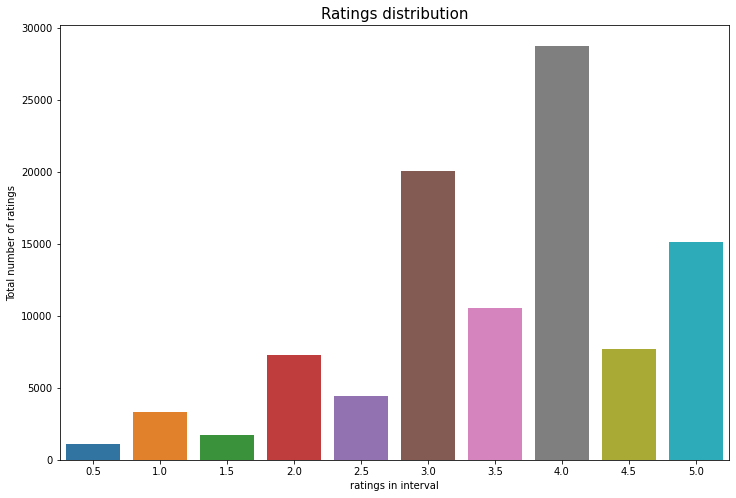

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Ratings distribution', fontsize=15)
sns.countplot(df['rating'])
ax.set_xlabel("ratings in interval")
ax.set_ylabel("Total number of ratings")

In [10]:
ratings_per_user = df.groupby(by='userId')['rating'].count()#.sort_values(ascending=False)
ratings_per_user.describe()

count     671.000000
mean      149.037258
std       231.226948
min        20.000000
25%        37.000000
50%        71.000000
75%       161.000000
max      2391.000000
Name: rating, dtype: float64

- Minimum number of ratings given by a user = 20
- Maximum number of ratings given by a user = 2391
- average ratings per user = 149

In [11]:
ratings_per_movie = df.groupby(by='movieId')['rating'].count()
ratings_per_movie.describe()

count    9066.000000
mean       11.030664
std        24.050800
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       341.000000
Name: rating, dtype: float64

- Minimum number of ratings to a movie = 1
- Maximum number of ratings to a movie = 341
- average ratings per movie = 11

**Loading as Surprise dataframe and train-test split**

In [6]:
reader = Reader()
ratings = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [7]:
ratings

**Splitting into train and test set**

In [8]:
train_ratings, test_ratings = train_test_split(ratings, test_size=.20, random_state = 42)
print("Size of trainset: ", train_ratings.n_ratings)
print("Size of testset: ", len(test_ratings))

Size of trainset:  80003
Size of testset:  20001


# **ML models for recommendation from Surprise library**

**Baseline method**

In [15]:
from surprise import BaselineOnly

In [16]:
baseline_model = BaselineOnly(verbose = False)
baseline_model.fit(train_ratings)

**Evaluating the results**

In [17]:
train_predictions = baseline_model.test(train_ratings.build_testset())
test_predictions = baseline_model.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions,verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions,verbose = False))

RMSE on training data :  0.8556854386787012
RMSE on test data:  0.8989464420419919


**Recommending Top 'n' movies**

In [4]:
movies = pd.read_csv("/kaggle/input/the-movies-dataset/movies_metadata.csv")
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [12]:
def get_top_n_recommendations(userId,predictions, n=5):
    predict_ratings = {}
    # loop for getting predictions for the user
    for uid, iid, true_r, est, _ in predictions:
        if (uid==userId):
            predict_ratings[iid] = est
    predict_ratings = sorted(predict_ratings.items(), key=lambda kv: kv[1],reverse=True)[:n]
    top_movies = [i[0] for i in predict_ratings]
    top_movies = [str(i) for i in top_movies]
    print("="*10,"Recommended movies for user {} :".format(userId),"="*10)
    print(movies[movies["id"].isin(top_movies)]["original_title"].to_string(index=False))

get_top_n_recommendations(450,test_predictions)

# **Using KNNBasic**

**User-user similarity based**

In [20]:
from surprise import KNNBasic
knn_model = KNNBasic(random_state = 42,verbose = False)
knn_model.fit(train_ratings)

**Evaluating the results**

In [21]:
train_predictions = knn_model.test(train_ratings.build_testset())
test_predictions = knn_model.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.7160931907176622
RMSE on test data:  0.9662515187787728


**Hyper-parameter tuning to find optimal value of k and min_k**

In [22]:
param_grid = {'k': list(range(10,45,5)),
             'min_k' : list(range(5,11))}
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], return_train_measures = True, cv = 5)
gs.fit(ratings)
gs.best_params['rmse']

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

{'k': 15, 'min_k': 5}

In [23]:
tuned_knn_model = KNNBasic(k = 15, min_k= 5,random_state = 42, verbose = False)
tuned_knn_model.fit(train_ratings)
train_predictions = tuned_knn_model.test(train_ratings.build_testset())
test_predictions = tuned_knn_model.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.7362583595173666
RMSE on test data:  0.9620821025717659


**Item-item similarity based**

In [24]:
knn_model_item_based = KNNBasic(user_based = False, random_state = 42)
knn_model_item_based.fit(train_ratings)

Computing the msd similarity matrix...
Done computing similarity matrix.


**Evaluating the results**

In [25]:
train_predictions = knn_model_item_based.test(train_ratings.build_testset())
test_predictions = knn_model_item_based.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.7160931907176622
RMSE on test data:  0.9662515187787728


**Matrix Factorization based method**

In [26]:
from surprise import SVD

In [27]:
svd_model = SVD(random_state = 42)
svd_model.fit(train_ratings)

In [28]:
train_predictions = svd_model.test(train_ratings.build_testset())
test_predictions = svd_model.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.6431314535515623
RMSE on test data:  0.9023287246946667


In [29]:
param_distributions  = {'n_factors': list(range(50,160,10)),'reg_all': np.arange(0.02,0.2,0.02),'n_epochs' : list(range(1,51))}
rs = RandomizedSearchCV(SVD, param_distributions, measures=['rmse'], return_train_measures = True, cv = 5, n_iter = 20)
rs.fit(ratings)
rs.best_params['rmse']

{'n_factors': 50, 'reg_all': 0.08, 'n_epochs': 48}

In [31]:
tuned_svd_model = SVD(n_factors=50, reg_all =0.08, n_epochs = 48, random_state = 42,verbose = False)
tuned_svd_model.fit(train_ratings)
train_predictions = tuned_svd_model.test(train_ratings.build_testset())
test_predictions = tuned_svd_model.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.6907287163090142
RMSE on test data:  0.8850155540496695


In [32]:
get_top_n_recommendations(450,test_predictions)

========== Recommended movies for user 450 : ==========
          Sleepless in Seattle
   The Man with the Golden Arm
               Men in Black II
Les Vacances de Monsieur Hulot


**NMF(Non-negative Matrix Factorization)**

In [5]:
from surprise import NMF

In [9]:
nmf_model = NMF(random_state = 42)
nmf_model.fit(train_ratings)

In [10]:
train_predictions = nmf_model.test(train_ratings.build_testset())
test_predictions = nmf_model.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.6262145965598339
RMSE on test data:  0.9549887019768525


In [13]:
get_top_n_recommendations(450,test_predictions)

========== Recommended movies for user 450 : ==========
              Sleepless in Seattle
Terminator 3: Rise of the Machines
    Les Vacances de Monsieur Hulot


**Hyper-parameter tuning to find optimal value of n_factors, reg_pu, reg_qi and n_epoch**

In [14]:
param_distributions  = {'n_factors': list(range(10,20,2)),'reg_pu': np.arange(0.02,0.2,0.02),'reg_qi': np.arange(0.02,0.2,0.02), 'n_epochs' : list(range(1,51))}
rs = RandomizedSearchCV(NMF, param_distributions, measures=['rmse'], return_train_measures = True, cv = 5, n_iter = 20)
rs.fit(ratings)
rs.best_params['rmse']

{'n_factors': 18, 'reg_pu': 0.1, 'reg_qi': 0.16, 'n_epochs': 26}

In [15]:
tuned_nmf_model = NMF(n_factors=18, reg_pu = 0.1, reg_qi = 0.16, n_epochs = 26, random_state = 42)
tuned_nmf_model.fit(train_ratings)
train_predictions = tuned_nmf_model.test(train_ratings.build_testset())
test_predictions = tuned_nmf_model.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.7007057956413112
RMSE on test data:  0.9273625997083494


**Handling Cold Start problem**

Cold start problem is a special case in recommendation whenever

- A new user joins the platform/service
- A new item is added to the platform/service
- Both(a new user joins and a new item is added)

In such scenarios, the Surprise library algorithms by default return the overall global average.

In [16]:
print(tuned_nmf_model.predict(672, 1721)) # unknown user id but known movie id
print(tuned_nmf_model.predict(43, 2277))  # known user id but unknown movie id
print(tuned_nmf_model.predict(671, 2277)) # unknown user id and unknown movie id

user: 672        item: 1721       r_ui = None   est = 3.55   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 43         item: 2277       r_ui = None   est = 3.55   {'was_impossible': True, 'reason': 'User and item are unknown.'}
user: 671        item: 2277       r_ui = None   est = 3.55   {'was_impossible': True, 'reason': 'User and item are unknown.'}


**Biased NMF**

In [17]:
biased_nmf_model = NMF(biased = True,random_state = 42)
biased_nmf_model.fit(train_ratings)
train_predictions = biased_nmf_model.test(train_ratings.build_testset())
test_predictions = biased_nmf_model.test(test_ratings)
print("RMSE on training data : ", accuracy.rmse(train_predictions,verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions,verbose = False))

RMSE on training data :  0.7020449950508578
RMSE on test data:  0.9033038517230036


In [18]:
print(biased_nmf_model.predict(672, 1721)) # unknown user id but known movie id
print(biased_nmf_model.predict(43, 2277))  # known user id but unknown movie id
print(biased_nmf_model.predict(671, 2277))# unknown user id and unknown movie id

user: 672        item: 1721       r_ui = None   est = 3.45   {'was_impossible': False}
user: 43         item: 2277       r_ui = None   est = 2.45   {'was_impossible': False}
user: 671        item: 2277       r_ui = None   est = 3.07   {'was_impossible': False}


In [19]:
get_top_n_recommendations(450,test_predictions)

========== Recommended movies for user 450 : ==========
              Sleepless in Seattle
Terminator 3: Rise of the Machines
    Les Vacances de Monsieur Hulot
